In [15]:
import sys
import os
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import pandas as pd
import numpy as np
from glob import glob
from keras.layers import Dense, Conv2D, BatchNormalization, Dropout, Flatten, MaxPooling2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches
import math
#import cv2
%matplotlib inline

cwd = os.getcwd()
data_dir = os.path.join(os.path.dirname(cwd), 'data')
input_dir = os.path.join(os.path.dirname(cwd), 'data', 'imgs')
output_dir = os.path.join(os.path.dirname(cwd), 'data', 'imgs')
TARGET_WIDTH = 600
TARGET_HEIGHT = 400

In [16]:
data_dir

'/home/ubuntu/courses/deeplearning1/nbs/data'

In [17]:
input_dir

'/home/ubuntu/courses/deeplearning1/nbs/data/imgs'

In [18]:
output_dir

'/home/ubuntu/courses/deeplearning1/nbs/data/imgs'

In [19]:
cwd

'/home/ubuntu/courses/deeplearning1/nbs/whale_recognition'

In [20]:
ann = pd.read_csv(os.path.join(cwd, 'bonnet_and_bbox.csv'))

In [21]:
ann.head()

,Image,whaleID,height,width,image_width,image_height,bboxx,bboxy,filename,x_1,y_1,x_2,y_2
0,w_7812.jpg,whale_48813,505.953358,505.953358,3072,2048,1411.343576,985.277591,w_7812.jpg,1668.211366,1370.097707,1647.792622,1108.737787
1,w_4598.jpg,whale_09913,478.725078,628.913338,3072,2048,1192.119312,1018.464137,w_4598.jpg,1639.625125,1212.873380,1353.762712,1265.962114
2,w_3828.jpg,whale_45062,459.951546,600.753039,3072,2048,1060.704585,826.035429,w_3828.jpg,1118.947159,908.634098,1345.595214,963.764706
3,w_8734.jpg,whale_74162,356.471430,337.585527,3072,2048,1496.707861,984.427725,w_8734.jpg,1690.671984,1223.082752,1682.504487,1069.942173
4,w_3251.jpg,whale_99558,538.248253,439.097259,3072,2048,1406.999818,644.481460,w_3251.jpg,1655.960120,1071.984048,1662.085743,878.005982


In [22]:
def find_new_bb(r, target_width, target_height):
    #print(r) 
    width_ratio = (target_width * 1.0) / r.image_width
    height_ratio = (target_height * 1.0) / r.image_height 
    
    bboxx_new = width_ratio * r.bboxx
    
    
    bboxy_new = height_ratio * r.bboxy
    
    width_final = width_ratio * r.width
    height_final = height_ratio * r.height
    
    
    return [r.Image,bboxx_new, bboxy_new, width_final, height_final]

In [23]:
bb_vals = ann.apply(lambda r: find_new_bb(r, TARGET_WIDTH, TARGET_HEIGHT), axis=1)

In [24]:
bb_vals = np.array([np.array(l) for l in bb_vals.values])

In [25]:
bb_vals = pd.DataFrame(bb_vals, columns=['Image','bboxx_new', 'bboxy_new', 'width_new', 'height_new'])

In [26]:
ann = ann.merge(bb_vals, on ='Image' )

In [27]:
ann.head()

,Image,whaleID,height,width,image_width,image_height,bboxx,bboxy,filename,x_1,y_1,x_2,y_2,bboxx_new,bboxy_new,width_new,height_new
0,w_7812.jpg,whale_48813,505.953358,505.953358,3072,2048,1411.343576,985.277591,w_7812.jpg,1668.211366,1370.097707,1647.792622,1108.737787,275.65304223,192.437029482,98.8190151393,98.8190151393
1,w_4598.jpg,whale_09913,478.725078,628.913338,3072,2048,1192.119312,1018.464137,w_4598.jpg,1639.625125,1212.873380,1353.762712,1265.962114,232.835803172,198.918776725,122.834636319,93.5009918246
2,w_3828.jpg,whale_45062,459.951546,600.753039,3072,2048,1060.704585,826.035429,w_3828.jpg,1118.947159,908.634098,1345.595214,963.764706,207.168864238,161.335044717,117.334577976,89.8342862629
3,w_8734.jpg,whale_74162,356.471430,337.585527,3072,2048,1496.707861,984.427725,w_8734.jpg,1690.671984,1223.082752,1682.504487,1069.942173,292.325754006,192.271040095,65.9346732219,69.6233262693
4,w_3251.jpg,whale_99558,538.248253,439.097259,3072,2048,1406.999818,644.481460,w_3251.jpg,1655.960120,1071.984048,1662.085743,878.005982,274.804652029,125.875285242,85.7611833516,105.12661185


In [71]:
def crop(r, target_width, target_height, input_dir, output_dir):    
    r = r[1]
    f_name = os.path.join(input_dir, r.Image)
    img = Image.open(f_name)
    img = img.resize((target_width, target_height))
    img.save(os.path.join(output_dir, r.Image))



In [28]:
ann.tail()

,Image,whaleID,height,width,image_width,image_height,bboxx,bboxy,filename,x_1,y_1,x_2,y_2,bboxx_new,bboxy_new,width_new,height_new
4539,w_9399.jpg,whale_09651,482.154012,476.547570,2464,1648,868.998510,504.579780,w_9399.jpg,1112.358923,584.933200,1031.848455,777.172483,211.606780032,122.470820388,116.04242776,117.027672816
4540,w_9403.jpg,whale_06967,219.548629,318.699623,3072,2048,2377.263116,1411.721294,w_9403.jpg,2623.808574,1494.652044,2437.998006,1480.358923,464.30920234,275.726815291,62.2460201746,42.8805916758
4541,w_9428.jpg,whale_55333,395.254161,399.206703,3072,2048,1494.060729,1288.528565,w_9428.jpg,1602.871386,1562.033898,1717.216351,1433.395813,291.808736051,251.665735324,77.9700591035,77.1980783203
4542,w_9450.jpg,whale_24458,469.338312,529.253841,3072,2048,279.605803,129.816980,w_9450.jpg,481.882353,218.480558,684.027916,441.044865,54.6105083664,25.3548788844,103.369890837,91.6676390438
4543,w_9468.jpg,whale_66205,489.310155,535.911122,3072,2048,1388.043093,812.188284,w_9468.jpg,1739.676969,888.215354,1643.708873,1025.020937,271.102166533,158.630524303,104.670141036,95.5683896414


% cd $data_dir
% mv w_7489.jpg for_bb/

for r in ann.iterrows():
    i +=1
    if i % 100 == 0: print(i)
    crop(r, TARGET_WIDTH, TARGET_HEIGHT, input_dir, output_dir)

In [29]:
f_name = 'bbox_{}_{}_.csv'.format(TARGET_WIDTH, TARGET_HEIGHT) 

In [30]:
ann.to_csv(f_name, index=False)


# Check

In [31]:
def check(r, target_width, target_height, input_dir):    
    r = r[1]
    f_name = os.path.join(input_dir, r.Image)
    img = Image.open(f_name)
    img = img.resize((target_width, target_height))
    img_arr = np.array(img, dtype=np.uint8)
    
    
    # Create figure and axes
    fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(img_arr)
     # Create a Rectangle patch
     
    rect = patches.Rectangle((r.bboxx_new ,r.bboxy_new),
                             r.width_new,
                             r.height_new, 
                             linewidth=1,
                             edgecolor='r',
                             facecolor='none')
    ax.add_patch(rect)

    plt.show()


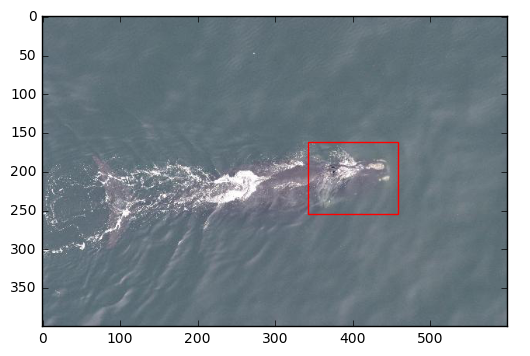

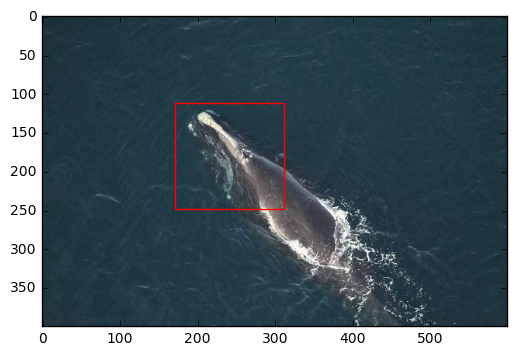

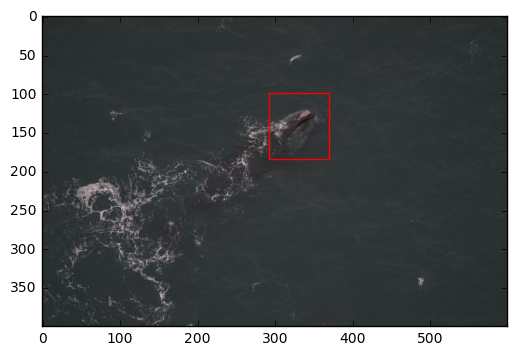

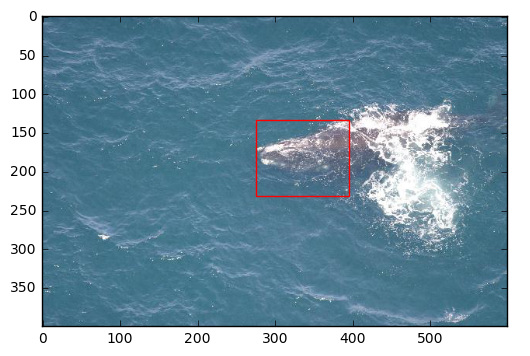

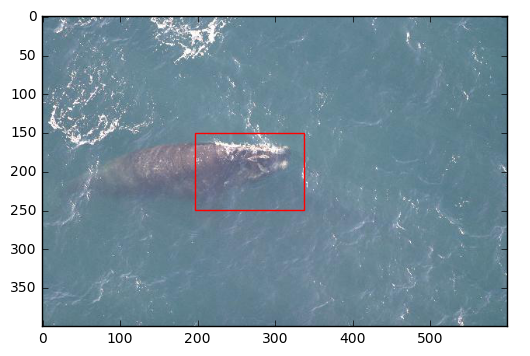

In [33]:
samp = ann.sample(frac=0.001)

for r in samp.iterrows():
    check(r, TARGET_WIDTH, TARGET_HEIGHT, output_dir)